In [1]:
%matplotlib inline

In [2]:
from genetwork.genetic.creatures import SndlibGene
from genetwork.genetic.crossovers import SinglePointRandomCrossover
from genetwork.genetic.evaluators import TotalCostWithConstraintsSndlibEvaluator
from genetwork.genetic.evolution import Evolution, NoChangeStoppingCriterion
from genetwork.genetic.initializers import RandomSndlibPopulationInitializer
from genetwork.genetic.mutations import DeltaMutation
from genetwork.genetic.selections import ThresholdSelection
from genetwork.genetic.successions import BestOverallSuccession
from genetwork.networks import SndlibNetworkXMLParser, SndlibTransponderType, SndlibNode, SndlibNetwork
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
network_path = "data/polska.xml"
pop_size = 200
max_trans = 1
succ_prob = 0.9
alpha = 25
beta = 7.5
selection_threshold = 0.75
selection_factor = 2
pc = 0.99
pm = 0.002

In [4]:
with open(network_path) as n:
    network = SndlibNetworkXMLParser[SndlibNode, float](4).parse(n)

In [5]:
transponders = [SndlibTransponderType(capacity=40,  cost=1),
                SndlibTransponderType(capacity=100,  cost=3),
                SndlibTransponderType(capacity=200, cost=5)]

In [6]:
initializer = RandomSndlibPopulationInitializer(pop_size, transponders, network.demands, max_trans, succ_prob)
crossover = SinglePointRandomCrossover(pc)
mutation = DeltaMutation(pm)

In [7]:
min_lambda = 32
max_lambda = 96
step = 2
n_runs = 5

def is_run_valid(lam):
    evaluator = TotalCostWithConstraintsSndlibEvaluator(network.demands, alpha, beta, lam)
    selection = ThresholdSelection(evaluator, selection_threshold, selection_factor)
    succession = BestOverallSuccession(evaluator)
    evolution = Evolution[SndlibGene](initializer, evaluator, selection, crossover, mutation, succession)
    stop_criterion = NoChangeStoppingCriterion()
    while not stop_criterion.should_stop(evolution):
        evolution.step()
        if evaluator.is_creature_valid(evolution.best_creature()):
            return True
    return False

scores = [(lam, np.mean([is_run_valid(lam) for _ in range(n_runs)])) 
          for lam in tqdm(range(min_lambda, max_lambda+1,  step))]

  0%|          | 0/33 [00:00<?, ?it/s]

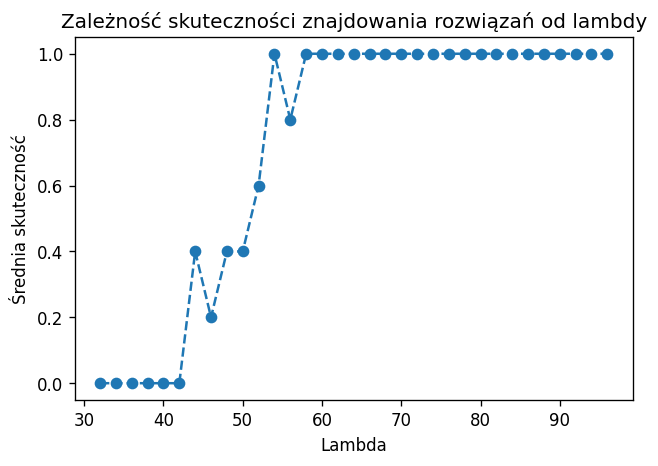

In [8]:
plt.figure(dpi=120)
plt.plot(*zip(*scores), linestyle='dashed', marker="o")
plt.title("Zależność skuteczności znajdowania rozwiązań od lambdy")
plt.xlabel("Lambda")
plt.ylabel("Średnia skuteczność")
plt.show()